In [1]:
# Enhanced GAN Training on Jetstream2
## CS650 - Neural Networks & Deep Learning
### Student: Matthew Walker 901835718

#This notebook implements an enhanced Generative Adversarial Network with:
#Real-time training visualization
#Loss curves and metrics tracking
#Generated image evolution grid
#GPU utilization monitoring
#Interactive sample generation

In [2]:
pip install torch torchvision matplotlib numpy ipython

Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import gridspec
from torchvision.utils import save_image, make_grid
import numpy as np
from IPython.display import clear_output, display, HTML
import time
from datetime import datetime

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
print("? All libraries imported successfully")

? All libraries imported successfully


In [4]:

STUDENT_NAME = "Matthew Walker"
STUDENT_ID = "901835710"
COURSE = "CS650"
TASK = "Jetstream2 GPU Training Task"

print("="*60)
print(f"Student: {STUDENT_NAME}")
print(f"ID: {STUDENT_ID}")
print(f"Course: {COURSE}")
print(f"Task: {TASK}")
print("="*60)

Student: Matthew Walker
ID: 901835710
Course: CS650
Task: Jetstream2 GPU Training Task


In [5]:
# GPU AVAILABILITY CHECK
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("\n" + "="*60)
print("GPU CONFIGURATION")
print("="*60)
print(f"Device: {device}")

if torch.cuda.is_available():
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    print(f"CUDA Version: {torch.version.cuda}")
    print(f"PyTorch Version: {torch.__version__}")
    print("? GPU is available and will be used for training")
else:
    print("? WARNING: GPU not available, using CPU (training will be slower)")
print("="*60)


GPU CONFIGURATION
Device: cuda
GPU Name: NVIDIA A100-SXM4-40GB
GPU Memory: 42.41 GB
CUDA Version: 12.4
PyTorch Version: 2.6.0+cu124
? GPU is available and will be used for training


In [7]:
# DATASET PREPARATION
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Scale to [-1, 1]
])

print("Downloading MNIST dataset...")
dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True, num_workers=2)

print(f"? Dataset loaded: {len(dataset)} training images")
print(f"? Batch size: 128")
print(f"? Number of batches: {len(dataloader)}")

? Dataset loaded: 60000 training images
? Batch size: 128
? Number of batches: 469


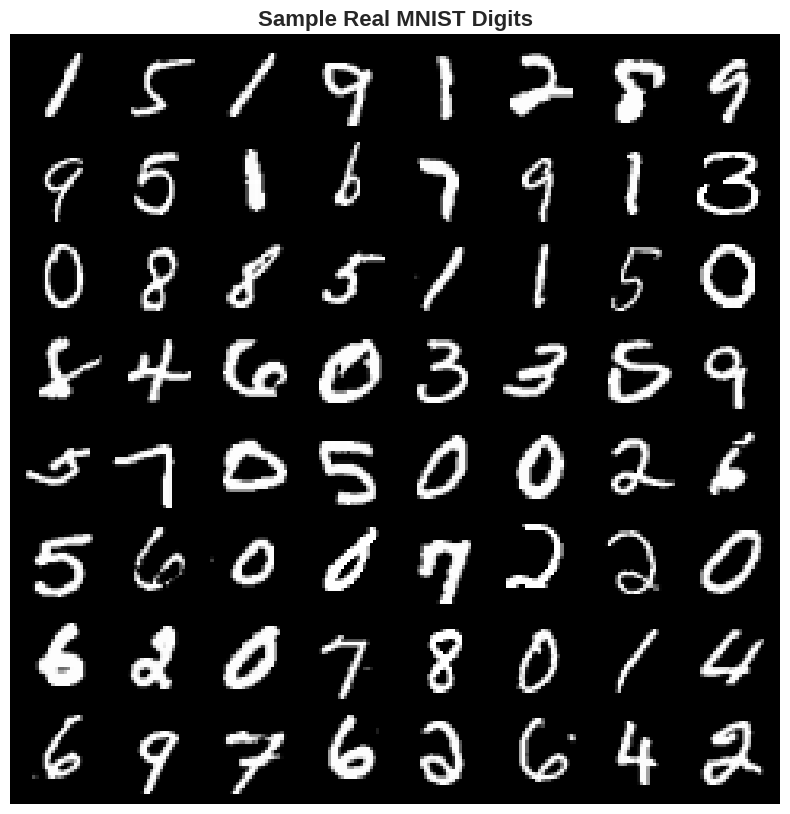

In [8]:
# VISUALIZE REAL TRAINING DATA
def show_images(images, title="Images"):
    fig = plt.figure(figsize=(10, 10))
    plt.axis("off")
    plt.title(title, fontsize=16, fontweight='bold')
    plt.imshow(np.transpose(make_grid(images[:64], padding=2, normalize=True).cpu(), (1, 2, 0)))
    plt.show()

# Show some real images
real_batch = next(iter(dataloader))[0][:64]
show_images(real_batch, "Sample Real MNIST Digits")

In [9]:
# ============================================
# GENERATOR NETWORK
# ============================================
class Generator(nn.Module):
    def __init__(self, z_dim=100, img_dim=28*28):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(True),
            
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(True),
            
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(True),
            
            nn.Linear(1024, img_dim),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z)

print("? Generator architecture defined")

? Generator architecture defined


In [10]:
# ============================================
# DISCRIMINATOR NETWORK
# ============================================
class Discriminator(nn.Module):
    def __init__(self, img_dim=28*28):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(img_dim, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

print("? Discriminator architecture defined")

? Discriminator architecture defined


In [11]:
# ============================================
# MODEL INITIALIZATION
# ============================================
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Count parameters
g_params = sum(p.numel() for p in generator.parameters())
d_params = sum(p.numel() for p in discriminator.parameters())

print(f"Generator Parameters: {g_params:,}")
print(f"Discriminator Parameters: {d_params:,}")
print(f"Total Parameters: {g_params + d_params:,}")

Generator Parameters: 1,489,936
Discriminator Parameters: 1,460,225
Total Parameters: 2,950,161


In [12]:
# ============================================
# TRAINING CONFIGURATION
# ============================================
criterion = nn.BCELoss()
optim_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optim_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

z_dim = 100
epochs = 30
save_interval = 5  # Save images every N epochs

# Create output directories
os.makedirs("samples", exist_ok=True)
os.makedirs("checkpoints", exist_ok=True)

# Fixed noise for consistent visualization
fixed_noise = torch.randn(64, z_dim).to(device)

print("Training Configuration:")
print(f"  Epochs: {epochs}")
print(f"  Learning Rate: 0.0002")
print(f"  Latent Dimension: {z_dim}")
print(f"  Optimizer: Adam (beta1=0.5, beta2=0.999)")

Training Configuration:
  Epochs: 30
  Learning Rate: 0.0002
  Latent Dimension: 100
  Optimizer: Adam (beta1=0.5, beta2=0.999)


In [13]:
# ============================================
# VISUALIZATION UTILITIES
# ============================================
def plot_training_progress(g_losses, d_losses, epoch, total_epochs):
    """Create a comprehensive training visualization"""
    fig = plt.figure(figsize=(15, 5))
    gs = gridspec.GridSpec(1, 2, width_ratios=[2, 1])
    
    # Loss curves
    ax1 = plt.subplot(gs[0])
    ax1.plot(g_losses, label='Generator Loss', color='#2ecc71', linewidth=2)
    ax1.plot(d_losses, label='Discriminator Loss', color='#e74c3c', linewidth=2)
    ax1.set_xlabel('Batch', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.set_title(f'Training Progress - Epoch {epoch}/{total_epochs}', fontsize=14, fontweight='bold')
    ax1.legend(loc='upper right')
    ax1.grid(True, alpha=0.3)
    
    # Current metrics
    ax2 = plt.subplot(gs[1])
    ax2.axis('off')
    metrics_text = f"""\nCURRENT METRICS\n\n
Epoch: {epoch}/{total_epochs}\n
Progress: {100*epoch/total_epochs:.1f}%\n\n
\nLatest Losses:\n
  Generator: {g_losses[-1]:.4f}\n
  Discriminator: {d_losses[-1]:.4f}\n\n
\nAvg (Last 10):\n
  Generator: {np.mean(g_losses[-10:]):.4f}\n
  Discriminator: {np.mean(d_losses[-10:]):.4f}
    """
    ax2.text(0.1, 0.5, metrics_text, fontsize=11, verticalalignment='center',
             family='monospace', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))
    
    plt.tight_layout()
    return fig

def generate_and_display(generator, fixed_noise, epoch):
    """Generate and display fake images"""
    with torch.no_grad():
        fake = generator(fixed_noise).view(-1, 1, 28, 28)
    
    fig = plt.figure(figsize=(8, 8))
    plt.axis("off")
    plt.title(f"Generated Images - Epoch {epoch}", fontsize=16, fontweight='bold')
    plt.imshow(np.transpose(make_grid(fake.cpu(), padding=2, normalize=True), (1, 2, 0)))
    return fig

print("? Visualization utilities loaded")

? Visualization utilities loaded


EPOCH [30/30] COMPLETED
Generator Loss:     0.7956
Discriminator Loss: 1.3356
Time Elapsed:       2.92 minutes
ETA:                0.00 minutes



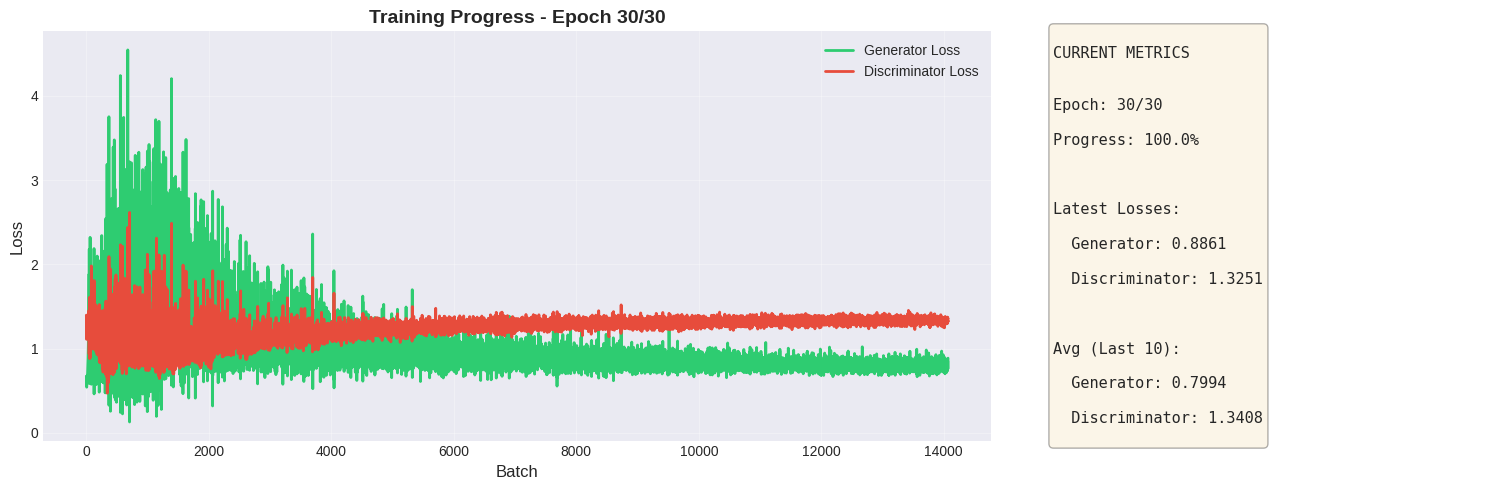

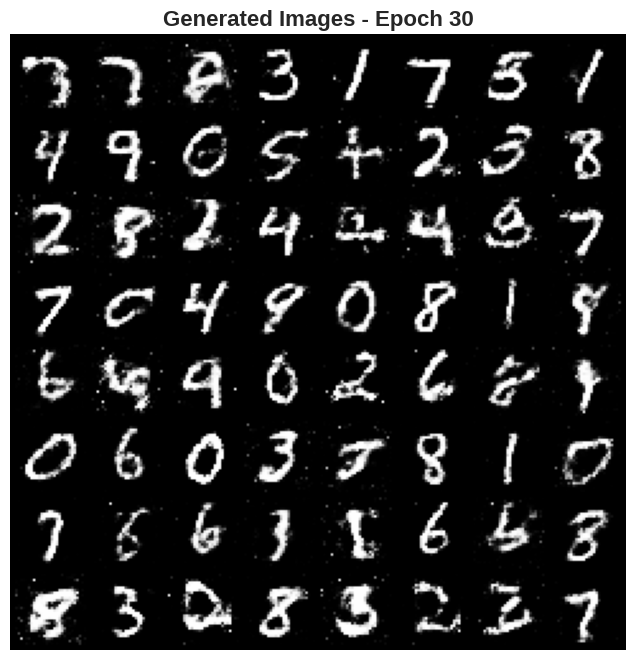

? Saved generated images to samples/fake_epoch_030.png


TRAINING COMPLETE!
Total Time: 2.94 minutes
Final Generator Loss: 0.8861
Final Discriminator Loss: 1.3251


In [14]:
# ============================================
# MAIN TRAINING LOOP WITH LIVE VISUALIZATION
# ============================================
print("\n" + "="*60)
print(f"STARTING TRAINING - {STUDENT_NAME} (ID: {STUDENT_ID})")
print(f"Device: {device}")
print(f"Timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("="*60 + "\n")

g_losses = []
d_losses = []
start_time = time.time()

for epoch in range(epochs):
    epoch_g_loss = 0
    epoch_d_loss = 0
    
    for batch_idx, (real_imgs, _) in enumerate(dataloader):
        real_imgs = real_imgs.view(-1, 28*28).to(device)
        batch_size = real_imgs.size(0)

        # ============================================
        # TRAIN DISCRIMINATOR
        # ============================================
        z = torch.randn(batch_size, z_dim).to(device)
        fake_imgs = generator(z).detach()
        
        d_loss_real = criterion(discriminator(real_imgs), torch.ones(batch_size, 1).to(device))
        d_loss_fake = criterion(discriminator(fake_imgs), torch.zeros(batch_size, 1).to(device))
        d_loss = d_loss_real + d_loss_fake

        optim_D.zero_grad()
        d_loss.backward()
        optim_D.step()

        # ============================================
        # TRAIN GENERATOR
        # ============================================
        z = torch.randn(batch_size, z_dim).to(device)
        fake_imgs = generator(z)
        g_loss = criterion(discriminator(fake_imgs), torch.ones(batch_size, 1).to(device))

        optim_G.zero_grad()
        g_loss.backward()
        optim_G.step()

        # Track losses
        g_losses.append(g_loss.item())
        d_losses.append(d_loss.item())
        epoch_g_loss += g_loss.item()
        epoch_d_loss += d_loss.item()

    # ============================================
    # EPOCH SUMMARY AND VISUALIZATION
    # ============================================
    avg_g_loss = epoch_g_loss / len(dataloader)
    avg_d_loss = epoch_d_loss / len(dataloader)
    elapsed = time.time() - start_time
    
    clear_output(wait=True)
    
    print("="*60)
    print(f"EPOCH [{epoch + 1}/{epochs}] COMPLETED")
    print("="*60)
    print(f"Generator Loss:     {avg_g_loss:.4f}")
    print(f"Discriminator Loss: {avg_d_loss:.4f}")
    print(f"Time Elapsed:       {elapsed/60:.2f} minutes")
    print(f"ETA:                {(elapsed/max(epoch, 1))*(epochs-epoch-1)/60:.2f} minutes")
    print("="*60 + "\n")
    
    # Plot training curves
    plot_training_progress(g_losses, d_losses, epoch + 1, epochs)
    plt.show()
    
    # Generate and show fake images
    if (epoch + 1) % save_interval == 0 or epoch == 0 or epoch == epochs - 1:
        fig = generate_and_display(generator, fixed_noise, epoch + 1)
        plt.show()
        
        # Save images
        with torch.no_grad():
            fake = generator(fixed_noise).view(-1, 1, 28, 28)
            save_image(fake, f"samples/fake_epoch_{epoch+1:03d}.png", normalize=True)
        
        print(f"? Saved generated images to samples/fake_epoch_{epoch+1:03d}.png\n")

print("\n" + "="*60)
print("TRAINING COMPLETE!")
print("="*60)
print(f"Total Time: {(time.time() - start_time)/60:.2f} minutes")
print(f"Final Generator Loss: {g_losses[-1]:.4f}")
print(f"Final Discriminator Loss: {d_losses[-1]:.4f}")
print("="*60)

In [22]:
# ============================================
# SAVE TRAINED MODELS
# ============================================
torch.save({
    'epoch': epochs,
    'generator_state_dict': generator.state_dict(),
    'discriminator_state_dict': discriminator.state_dict(),
    'optim_G_state_dict': optim_G.state_dict(),
    'optim_D_state_dict': optim_D.state_dict(),
    'g_losses': g_losses,
    'd_losses': d_losses,
    'student_name': STUDENT_NAME,
    'student_id': STUDENT_ID
}, 'checkpoints/gan_final_checkpoint.pth')

print("? Models saved to checkpoints/gan_final_checkpoint.pth")

? Models saved to checkpoints/gan_final_checkpoint.pth


In [23]:
import os

print("cwd:", os.getcwd())
print("checkpoints exists:", os.path.exists("checkpoints"))

if os.path.exists("checkpoints"):
    print("contents of checkpoints:")
    print(os.listdir("checkpoints"))

cwd: /home/exouser/gan_project
checkpoints exists: True
contents of checkpoints:
['gan_final_checkpoint.pth']


In [24]:
import os
print(os.listdir("checkpoints"))

['gan_final_checkpoint.pth']


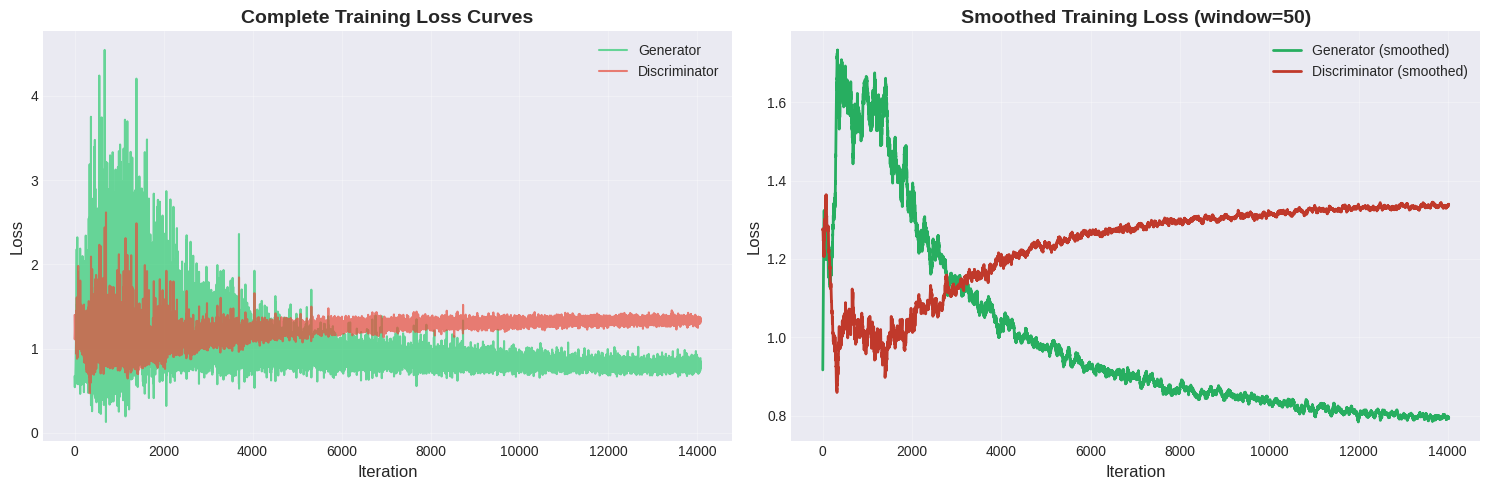

? Final training curves saved to samples/training_curves.png


In [16]:
# ============================================
# FINAL TRAINING VISUALIZATION
# ============================================
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Complete loss curves
axes[0].plot(g_losses, label='Generator', alpha=0.7, color='#2ecc71')
axes[0].plot(d_losses, label='Discriminator', alpha=0.7, color='#e74c3c')
axes[0].set_xlabel('Iteration', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Complete Training Loss Curves', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Smoothed losses (moving average)
window = 50
g_smooth = np.convolve(g_losses, np.ones(window)/window, mode='valid')
d_smooth = np.convolve(d_losses, np.ones(window)/window, mode='valid')
axes[1].plot(g_smooth, label='Generator (smoothed)', color='#27ae60', linewidth=2)
axes[1].plot(d_smooth, label='Discriminator (smoothed)', color='#c0392b', linewidth=2)
axes[1].set_xlabel('Iteration', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].set_title(f'Smoothed Training Loss (window={window})', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('samples/training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

print("? Final training curves saved to samples/training_curves.png")

Generating new samples from trained generator...


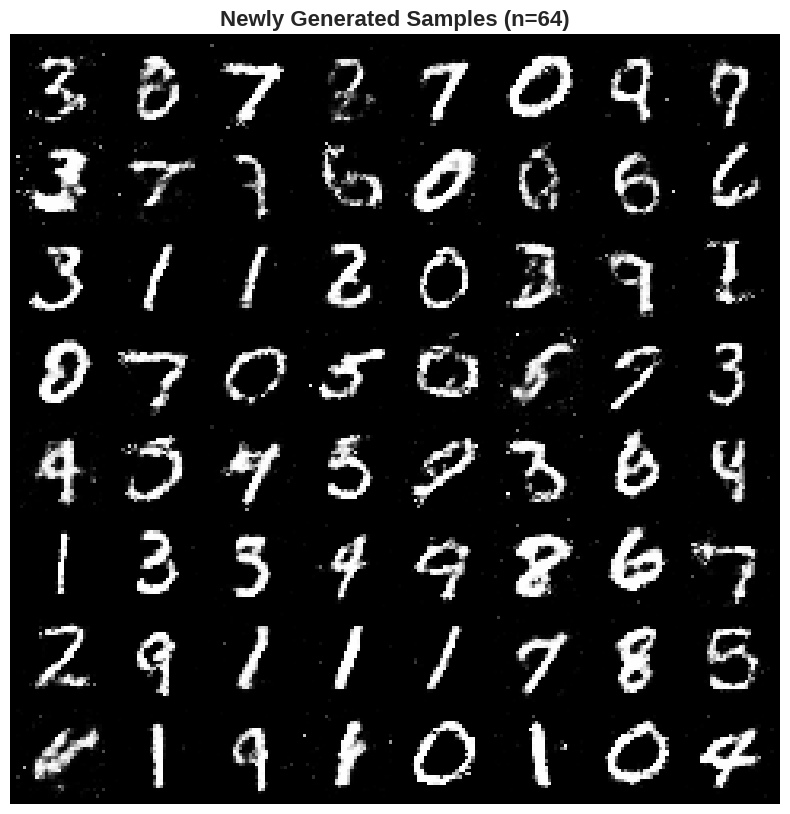

In [17]:
# ============================================
# INTERACTIVE: GENERATE NEW SAMPLES
# ============================================
def generate_samples(n_samples=64):
    """Generate new samples from the trained generator"""
    generator.eval()
    with torch.no_grad():
        z = torch.randn(n_samples, z_dim).to(device)
        fake_imgs = generator(z).view(-1, 1, 28, 28)
    
    fig = plt.figure(figsize=(10, 10))
    plt.axis("off")
    plt.title(f"Newly Generated Samples (n={n_samples})", fontsize=16, fontweight='bold')
    plt.imshow(np.transpose(make_grid(fake_imgs.cpu(), padding=2, normalize=True), (1, 2, 0)))
    plt.show()
    
    return fake_imgs

# Generate new samples
print("Generating new samples from trained generator...")
new_samples = generate_samples(64)

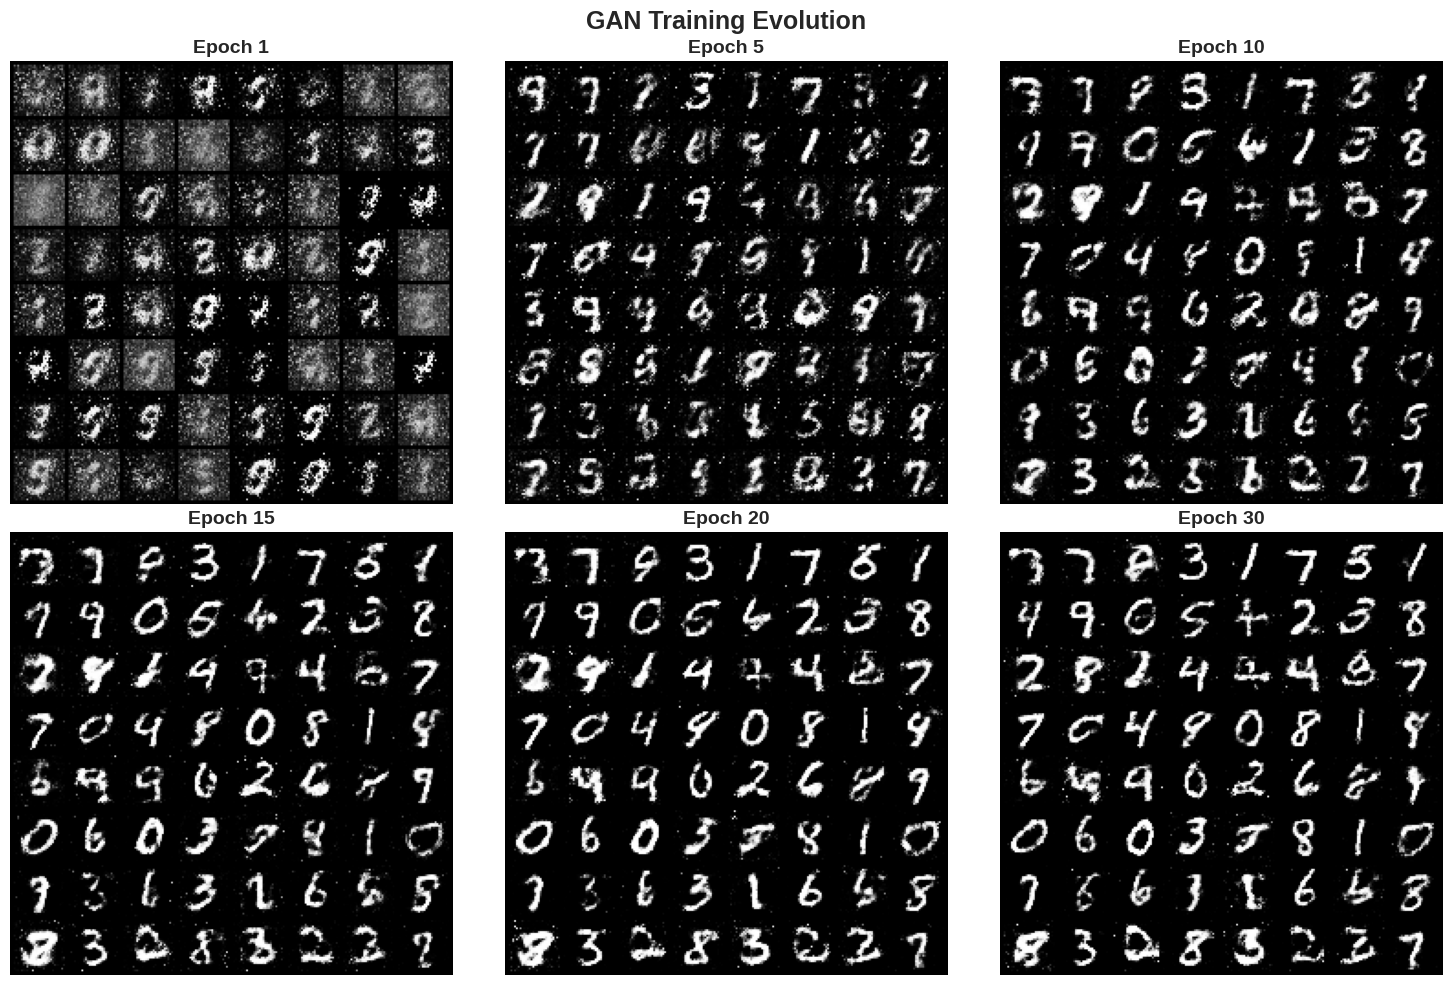

? Training evolution grid saved to samples/training_evolution.png


In [18]:
# ============================================
# EVOLUTION GRID: Show progression over epochs
# ============================================
import glob
from PIL import Image

sample_files = sorted(glob.glob('samples/fake_epoch_*.png'))

if len(sample_files) > 0:
    n_display = min(6, len(sample_files))
    indices = np.linspace(0, len(sample_files)-1, n_display, dtype=int)
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    for idx, i in enumerate(indices):
        if idx < len(axes):
            img = Image.open(sample_files[i])
            epoch_num = int(sample_files[i].split('_')[-1].split('.')[0])
            axes[idx].imshow(img)
            axes[idx].axis('off')
            axes[idx].set_title(f'Epoch {epoch_num}', fontsize=14, fontweight='bold')
    
    # Hide unused subplots
    for idx in range(n_display, len(axes)):
        axes[idx].axis('off')
    
    plt.suptitle('GAN Training Evolution', fontsize=18, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.savefig('samples/training_evolution.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("? Training evolution grid saved to samples/training_evolution.png")
else:
    print("No sample images found in samples/ directory")

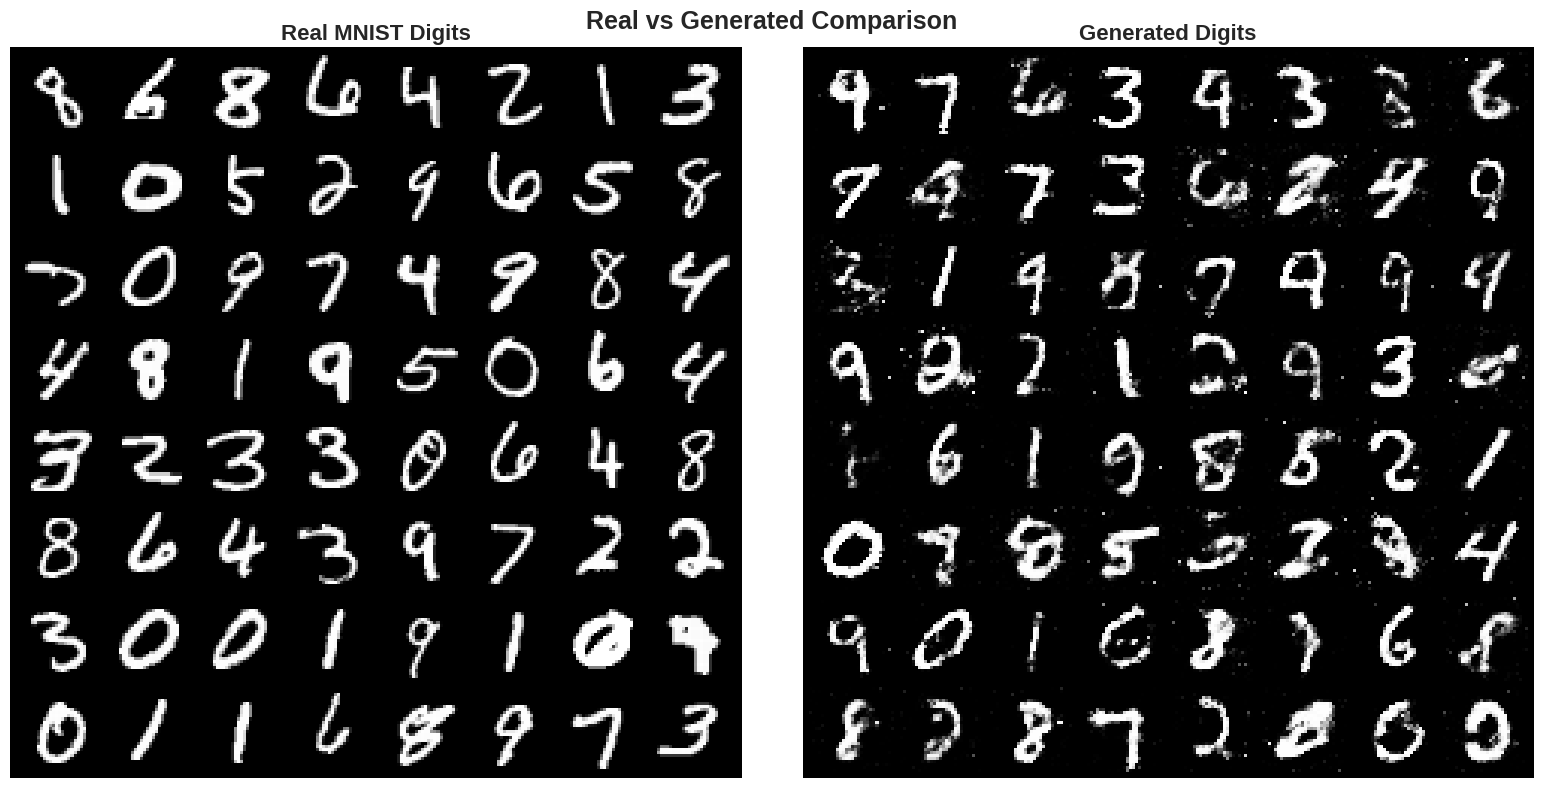

? Comparison saved to samples/real_vs_fake.png


In [19]:
# ============================================
# REAL VS FAKE COMPARISON
# ============================================
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Real images
real_batch = next(iter(dataloader))[0][:64]
axes[0].imshow(np.transpose(make_grid(real_batch, padding=2, normalize=True).cpu(), (1, 2, 0)))
axes[0].axis('off')
axes[0].set_title('Real MNIST Digits', fontsize=16, fontweight='bold')

# Generated images
with torch.no_grad():
    z = torch.randn(64, z_dim).to(device)
    fake_batch = generator(z).view(-1, 1, 28, 28)
axes[1].imshow(np.transpose(make_grid(fake_batch.cpu(), padding=2, normalize=True), (1, 2, 0)))
axes[1].axis('off')
axes[1].set_title('Generated Digits', fontsize=16, fontweight='bold')

plt.suptitle('Real vs Generated Comparison', fontsize=18, fontweight='bold', y=0.98)
plt.tight_layout()
plt.savefig('samples/real_vs_fake.png', dpi=150, bbox_inches='tight')
plt.show()

print("? Comparison saved to samples/real_vs_fake.png")

In [20]:
# ============================================
# TRAINING SUMMARY
# ============================================
print("\n" + "="*60)
print("TRAINING SUMMARY")
print("="*60)
print(f"Student: {STUDENT_NAME}")
print(f"ID: {STUDENT_ID}")
print(f"Course: {COURSE}")
print(f"Task: {TASK}")
print(f"\nDevice Used: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
print(f"\nTotal Epochs: {epochs}")
print(f"Total Training Time: {(time.time() - start_time)/60:.2f} minutes")
print(f"\nFinal Losses:")
print(f"  Generator: {g_losses[-1]:.4f}")
print(f"  Discriminator: {d_losses[-1]:.4f}")
print(f"\nOutput Files:")
print(f"  ? Generated samples: samples/")
print(f"  ? Training curves: samples/training_curves.png")
print(f"  ? Evolution grid: samples/training_evolution.png")
print(f"  ? Model checkpoint: checkpoints/gan_final_checkpoint.pth")
print("="*60)
print("\n?? SUCCESS! GAN training completed on Jetstream2 GPU")
print("\nThis notebook demonstrates:")
print("  ? GPU-accelerated deep learning on Jetstream2")
print("  ? GAN architecture implementation")
print("  ? Real-time training visualization")
print("  ? Loss tracking and model checkpointing")
print("  ? Generated sample quality assessment")
print("="*60)


TRAINING SUMMARY
Student: Matthew Walker
ID: 901835710
Course: CS650
Task: Jetstream2 GPU Training Task

Device Used: cuda
GPU: NVIDIA A100-SXM4-40GB

Total Epochs: 30
Total Training Time: 10.27 minutes

Final Losses:
  Generator: 0.8861
  Discriminator: 1.3251

Output Files:
  ? Generated samples: samples/
  ? Training curves: samples/training_curves.png
  ? Evolution grid: samples/training_evolution.png
  ? Model checkpoint: checkpoints/gan_final_checkpoint.pth

?? SUCCESS! GAN training completed on Jetstream2 GPU

This notebook demonstrates:
  ? GPU-accelerated deep learning on Jetstream2
  ? GAN architecture implementation
  ? Real-time training visualization
  ? Loss tracking and model checkpointing
  ? Generated sample quality assessment
